In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader
from experiments import train_network
from utils import compute_fluctuations, ensemble_predictions

In [21]:
torch.manual_seed(42)
np.random.seed(42)
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])  # Flatten input
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [15]:
widths = [5,10,50,100, 200, 500,1000,2000, 5000]  
ensemble_sizes = [1, 5, 10, 15, 20] 
epochs = 5 
num_seeds = 20 

fluctuation_results = []
test_error_results = {}

for width in widths:
    print(f"\n[INFO] Starting experiments for width {width}")

    models = [train_network(width, seed=i, train_loader=train_loader, epochs=epochs) for i in range(num_seeds)]
    print(f"[INFO] Trained {num_seeds} models for width {width}")

    predictions = []
    with torch.no_grad():
        for model in models:
            model.eval()
            all_preds = []
            for batch_x, _ in test_loader:
                preds = model(batch_x)
                all_preds.append(preds)
            predictions.append(torch.cat(all_preds))

    fluctuation = compute_fluctuations(predictions)
    fluctuation_results.append(fluctuation)
    print(f"[INFO] Fluctuation for width {width}: {fluctuation:.5f}")

    for n in ensemble_sizes:
        print(f"[INFO] Testing ensemble size {n} for width {width}")
        selected_models = models[:n]  
        ensemble_preds = ensemble_predictions(selected_models, test_loader)

        true_labels = torch.cat([labels for _, labels in test_loader])
        test_error = (ensemble_preds.softmax(dim=1).argmax(dim=1) != true_labels).float().mean().item()

        if width not in test_error_results:
            test_error_results[width] = {}
        test_error_results[width][n] = test_error

        print(f"[INFO] Test error for ensemble size {n}, width {width}: {test_error:.5f}")

print("[INFO] All training complete")



[INFO] Starting experiments for width 5
[INFO] Trained 20 models for width 5
[INFO] Computing fluctuations...
[INFO] Fluctuation for width 5: 1.74683
[INFO] Testing ensemble size 1 for width 5
[INFO] Computing ensemble predictions...
[INFO] Test error for ensemble size 1, width 5: 0.10450
[INFO] Testing ensemble size 5 for width 5
[INFO] Computing ensemble predictions...
[INFO] Test error for ensemble size 5, width 5: 0.10190
[INFO] Testing ensemble size 10 for width 5
[INFO] Computing ensemble predictions...
[INFO] Test error for ensemble size 10, width 5: 0.09730
[INFO] Testing ensemble size 15 for width 5
[INFO] Computing ensemble predictions...
[INFO] Test error for ensemble size 15, width 5: 0.09700
[INFO] Testing ensemble size 20 for width 5
[INFO] Computing ensemble predictions...
[INFO] Test error for ensemble size 20, width 5: 0.09800

[INFO] Starting experiments for width 10
[INFO] Trained 20 models for width 10
[INFO] Computing fluctuations...
[INFO] Fluctuation for width 1

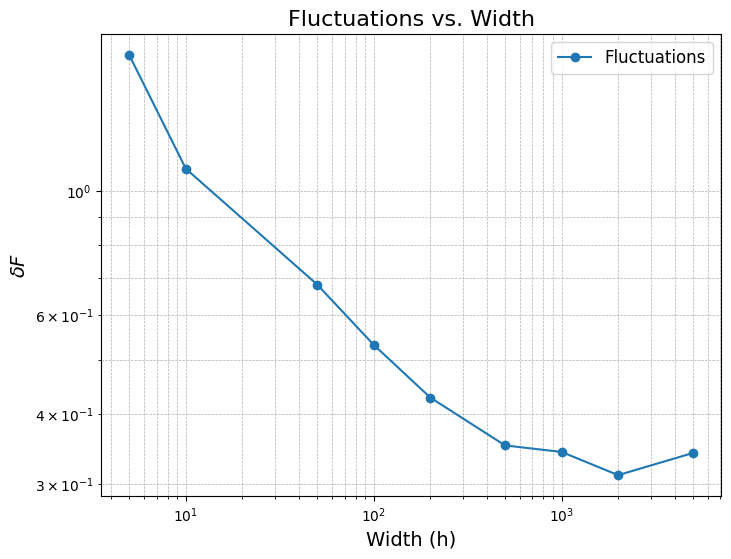

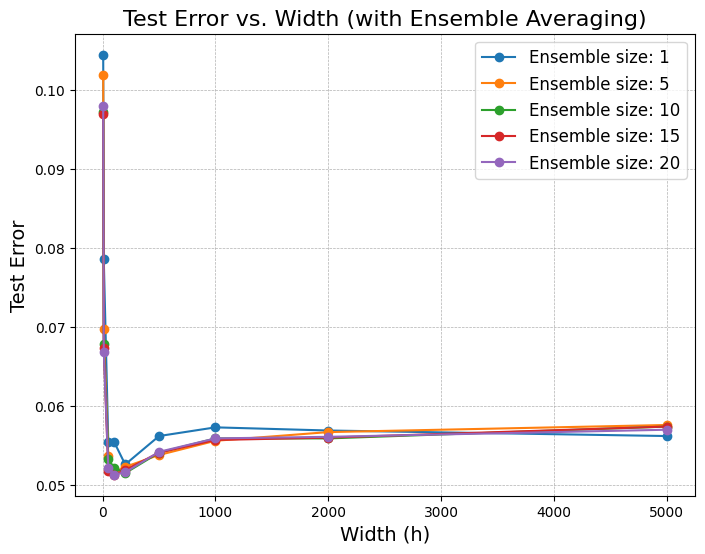

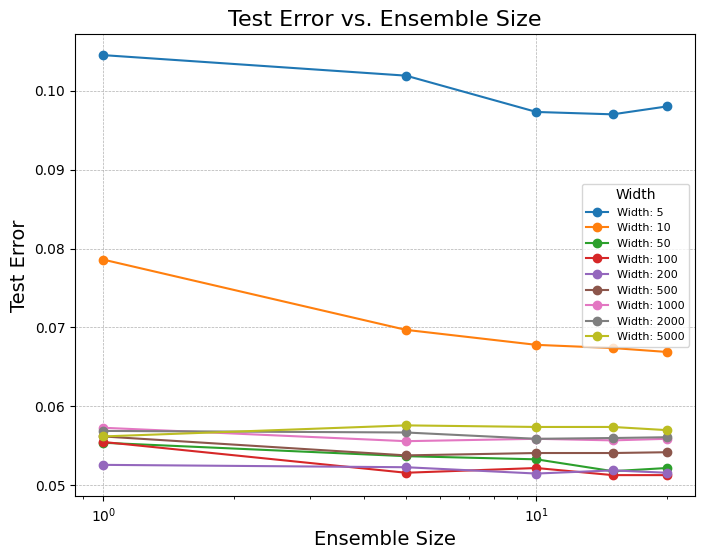

[INFO] Experiment completed.


In [31]:
path_file_1 = os.path.join(output_dir, "fluctuations.pdf")
path_file_2 = os.path.join(output_dir, "testerror.pdf")
path_file_3 = os.path.join(output_dir, "test_error_vs_ensemble_size.pdf")


plt.figure(figsize=(8, 6))
plt.loglog(widths, fluctuation_results, marker='o', label="Fluctuations")
plt.xlabel("Width (h)", fontsize=14)
plt.ylabel(r"$\delta F$", fontsize=14)
plt.title("Fluctuations vs. Width", fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.savefig(path_file_1)
plt.show()


plt.figure(figsize=(8, 6))
for n in ensemble_sizes:
    errors = [test_error_results[w][n] for w in widths]
    plt.plot(widths, errors, marker='o', label=f"Ensemble size: {n}")

plt.xlabel("Width (h)", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.title("Test Error vs. Width (with Ensemble Averaging)", fontsize=16)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.savefig(path_file_2)
plt.show()

test_errors_by_ensemble = {n: [] for n in ensemble_sizes}

for n in ensemble_sizes:
    for width in widths:
        test_errors_by_ensemble[n].append(test_error_results[width][n])

plt.figure(figsize=(8, 6))
for width in widths:
    plt.plot(ensemble_sizes, [test_error_results[width][n] for n in ensemble_sizes], marker='o', label=f"Width: {width}")

plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.title("Test Error vs. Ensemble Size", fontsize=16)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xscale("log")  # Log scale for ensemble size if needed
plt.legend(title="Width", fontsize=8)
plt.savefig(path_file_3)
plt.show()

print("[INFO] Experiment completed.")